In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import cv2

from keras import callbacks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
from keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti, compute capability 7.5


In [3]:
class FingerAccuracyCallback(callbacks.Callback):
    def __init__(self, target_accuracy=0.90):
        super(FingerAccuracyCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_finger_acc = logs.get('val_finger_accuracy')
        if val_finger_acc is not None and val_finger_acc >= self.target_accuracy:
            print(f"\nReached {val_finger_acc:.2f} validation finger accuracy. Stopping training.")
            self.model.stop_training = True

In [4]:
def load_data(paths):
    IDs, fingerNums, images, genders = [], [], [], []
    
    for path in paths:
        print(f"Processing directory: {path}")
        for img in os.listdir(path):
            parts = img.split('_')
            if len(parts) >= 5:
                ID = int(parts[0]) - 1
                gender = 0 if parts[1] == 'M' else 1
                hand = 0 if 'right' in parts else 1
                
                finger_names = ['thumb', 'index', 'middle', 'ring', 'little']
                finger = next((finger_names.index(part) for part in parts if part in finger_names), None)
                
                if finger is not None:
                    fingerNum = hand * 5 + finger

                    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    img_resize = cv2.resize(img_array, (150, 150))
                    
                    IDs.append(ID)
                    fingerNums.append(fingerNum)
                    images.append(img_resize)
                    genders.append(gender)
    
    return np.array(IDs), np.array(fingerNums), np.array(images), np.array(genders)

In [5]:
data_dirs = [
    r'SOCOFing\Real',
    r'SOCOFing\Altered\Altered-Medium'
]

In [6]:
IDs, fingerNums, images, genders = load_data(data_dirs)

Processing directory: SOCOFing\Real
Processing directory: SOCOFing\Altered\Altered-Medium


In [7]:
len(IDs), len(fingerNums), len(images), len(genders)

(23067, 23067, 23067, 23067)

In [8]:
images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)

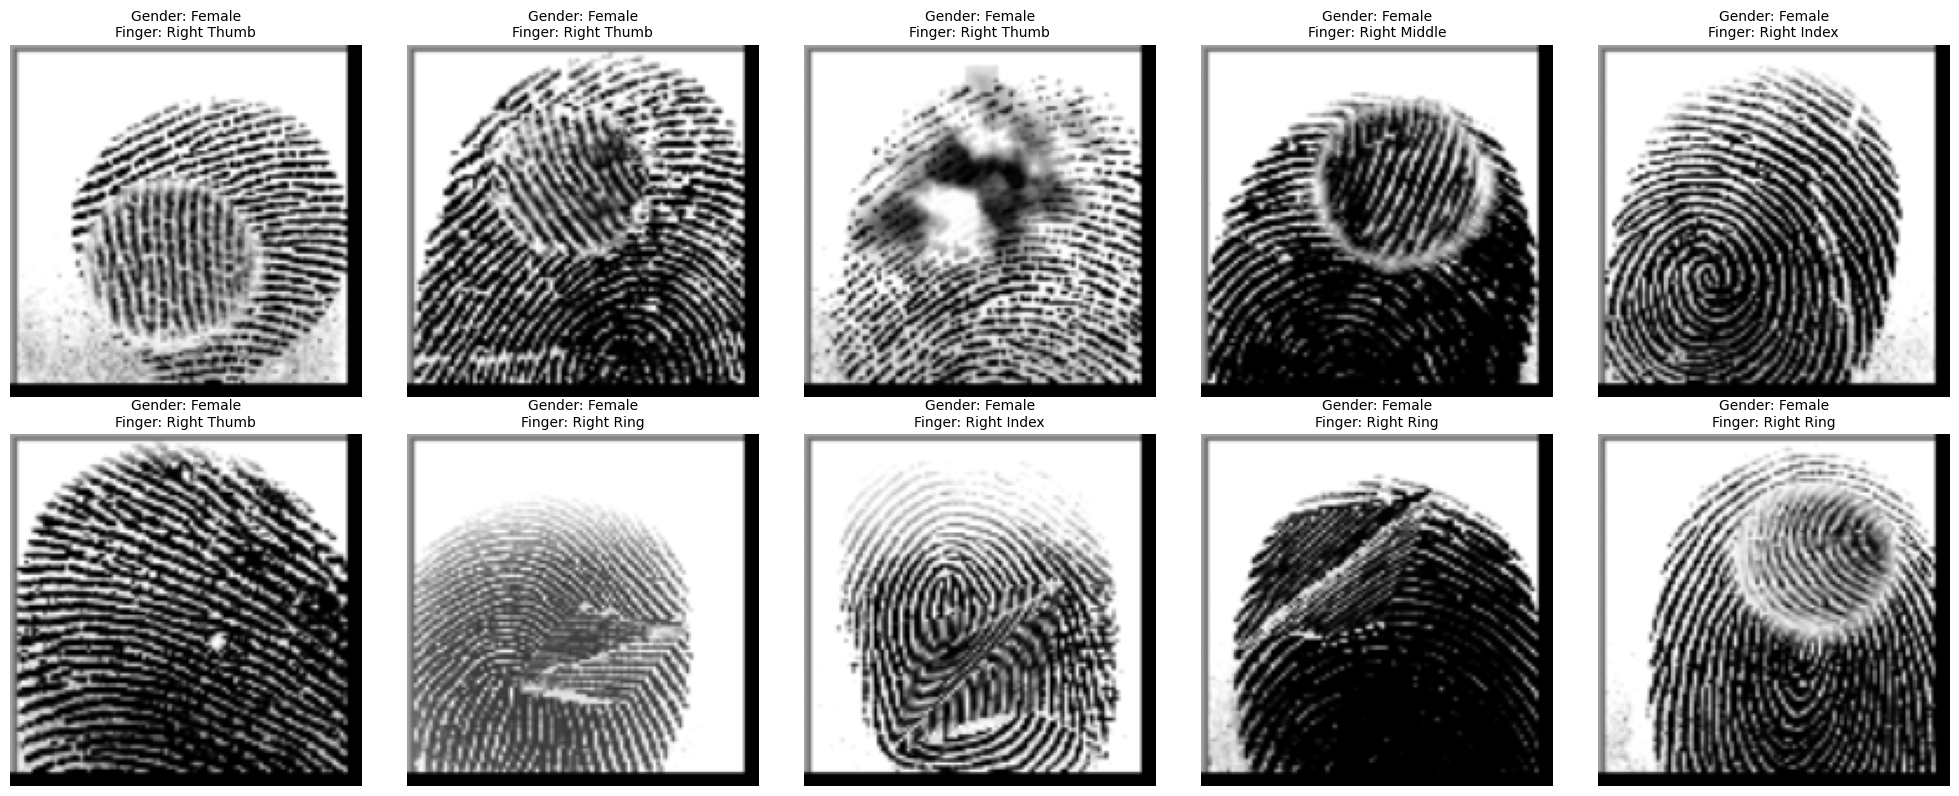

In [9]:
num_samples=10

total_samples = images.shape[0]
random_indices = random.sample(range(total_samples), num_samples)


fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

finger_names = ['Left Thumb', 'Left Index', 'Left Middle', 'Left Ring', 'Left Little',
                'Right Thumb', 'Right Index', 'Right Middle', 'Right Ring', 'Right Little']

for i, idx in enumerate(random_indices):
    img = images[idx].squeeze() 
    gender = "Male" if genders[idx] == 0 else "Female"
    finger = finger_names[fingerNums[idx]]

    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Gender: {gender}\nFinger: {finger}", fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
X_train, X_test, y_train_genders, y_test_genders, y_train_fingers, y_test_fingers = train_test_split(
    images, genders, fingerNums, test_size=0.3, random_state=42)

In [11]:
input_layer = Input(shape=(150, 150, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

gender_output = Dense(1, activation='sigmoid', name='gender')(x)
finger_output = Dense(10, activation='softmax', name='finger')(x)

model = Model(inputs=input_layer, outputs=[gender_output, finger_output])

In [12]:
model.compile(optimizer='adam',
              loss={'gender': 'binary_crossentropy', 'finger': 'sparse_categorical_crossentropy'},
              metrics={'gender': 'accuracy', 'finger': 'accuracy'})

In [13]:
finger_accuracy_callback = FingerAccuracyCallback(target_accuracy=0.9)

In [14]:
history = model.fit(X_train, 
                    {'gender': y_train_genders, 'finger': y_train_fingers},
                    epochs=50, 
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[finger_accuracy_callback])

Epoch 1/50
404/404 [==============================] - 22s 44ms/step - loss: 1.1505 - gender_loss: 0.0029 - finger_loss: 1.1476 - gender_accuracy: 0.9981 - finger_accuracy: 0.5222 - val_loss: 0.9590 - val_gender_loss: 1.2284e-05 - val_finger_loss: 0.9590 - val_gender_accuracy: 1.0000 - val_finger_accuracy: 0.6084
Epoch 2/50
404/404 [==============================] - 15s 38ms/step - loss: 0.8549 - gender_loss: 5.6847e-06 - finger_loss: 0.8549 - gender_accuracy: 1.0000 - finger_accuracy: 0.6680 - val_loss: 0.7795 - val_gender_loss: 1.3603e-06 - val_finger_loss: 0.7795 - val_gender_accuracy: 1.0000 - val_finger_accuracy: 0.6950
Epoch 3/50
404/404 [==============================] - 15s 38ms/step - loss: 0.6333 - gender_loss: 8.7904e-07 - finger_loss: 0.6333 - gender_accuracy: 1.0000 - finger_accuracy: 0.7630 - val_loss: 0.6395 - val_gender_loss: 2.2853e-07 - val_finger_loss: 0.6395 - val_gender_accuracy: 1.0000 - val_finger_accuracy: 0.7632
Epoch 4/50
404/404 [==============================

In [15]:
loss, gender_loss, finger_loss, gender_acc, finger_acc = model.evaluate(X_test, {'gender': y_test_genders, 'finger': y_test_fingers})
print(f'Gender Accuracy: {gender_acc}')
print(f'Finger Accuracy: {finger_acc}')

217/217 [==============================] - 2s 11ms/step - loss: 0.3488 - gender_loss: 1.1024e-09 - finger_loss: 0.3488 - gender_accuracy: 1.0000 - finger_accuracy: 0.8886
Gender Accuracy: 1.0
Finger Accuracy: 0.8885999321937561


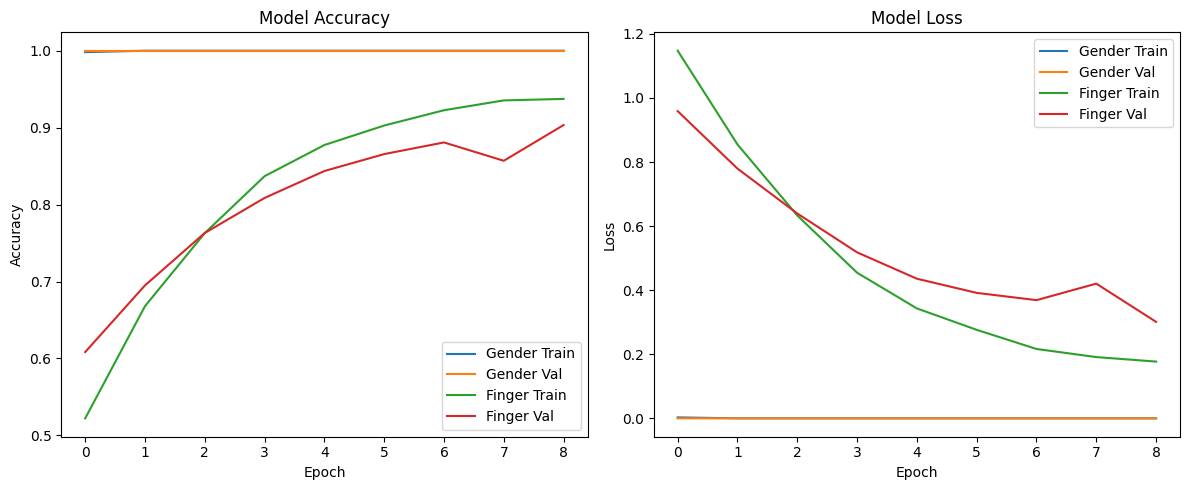

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.plot(history.history['finger_accuracy'])
plt.plot(history.history['val_finger_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Gender Train', 'Gender Val', 'Finger Train', 'Finger Val'], loc='lower right')


plt.subplot(122)
plt.plot(history.history['gender_loss'])
plt.plot(history.history['val_gender_loss'])
plt.plot(history.history['finger_loss'])
plt.plot(history.history['val_finger_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Gender Train', 'Gender Val', 'Finger Train', 'Finger Val'], loc='upper right')

plt.tight_layout()
plt.show()